# Net Time Project — Coding Assessment
**PhD Programme: Science & Health in Football | Saarland University**

---

## Overview

This notebook addresses the three coding tasks based on the publicly available Bundesliga dataset described in:

> Bassek, M., Rein, R., Weber, H. & Memmert, D. (2025). *An integrated dataset of spatiotemporal and event data in elite soccer.* Scientific Data, 12, 195. https://doi.org/10.1038/s41597-025-04505-y

The dataset contains official DFL match information, event data, and high-frequency TRACAB tracking data (25 Hz) from **7 German Bundesliga matches** (2 Bundesliga 1, 5 Bundesliga 2), covering 207 players and over 1 million tracking frames.

### Tasks Covered
1. **Task 1** — Load and parse all three data modalities from local files into flat DataFrames
2. **Task 2** — Exploratory visualizations of tracking and event data
3. **Task 3** — Two methodological approaches to quantify net playing time

---

## Environment Setup

In [1]:
# Install required packages if not already installed
# !pip install floodlight pandas numpy matplotlib seaborn scipy

import warnings
warnings.filterwarnings('ignore')

import os
import xml.etree.ElementTree as ET
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from scipy.ndimage import gaussian_filter

import floodlight
# floodlight 0.4.0: match info is split across two functions;
# net/gross playing times are read directly from the XML.
from floodlight.io.dfl import (
    read_position_data_xml,
    read_event_data_xml,
    read_pitch_from_mat_info_xml,
    read_teamsheets_from_mat_info_xml,
)

print(f'floodlight version: {floodlight.__version__}')
print('Environment ready.')


floodlight version: 0.4.0
Environment ready.


---
## Configuration — Set Your Local Data Path Here

In [2]:
# ─────────────────────────────────────────────────────────────────────────────
# SET THIS to the folder containing all your downloaded XML files.
#
# Expected flat structure (all files in one folder, no subfolders):
#
#   DATA_DIR/
#   ├── DFL_02_01_matchinformation_DFL-COM-000001_DFL-MAT-J03WMX.xml
#   ├── DFL_03_02_events_raw_DFL-COM-000001_DFL-MAT-J03WMX.xml
#   ├── DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WMX.xml
#   ├── DFL_02_01_matchinformation_DFL-COM-000002_DFL-MAT-J03WR9.xml
#   └── ... (all 7 matches, 3 files each)
# ─────────────────────────────────────────────────────────────────────────────

import re

DATA_DIR = Path(r"C:\Users\thakk\Downloads\Bassek data")   # <-- your path

# ── Auto-discover all unique match IDs from filenames ────────────────────────
# Match ID is the last component of the filename, e.g. 'DFL-MAT-J03WMX'
_mat_pattern = re.compile(r'(DFL-MAT-[A-Z0-9]+)\.xml$', re.IGNORECASE)

MATCH_IDS = sorted(set(
    m.group(1)
    for f in DATA_DIR.glob('*.xml')
    for m in [_mat_pattern.search(f.name)]
    if m
))

print(f"Data folder : {DATA_DIR}")
print(f"Found {len(MATCH_IDS)} match(es):")
for mid in MATCH_IDS:
    print(f"  {mid}")


Data folder : C:\Users\thakk\Downloads\Bassek data
Found 7 match(es):
  DFL-MAT-J03WMX
  DFL-MAT-J03WN1
  DFL-MAT-J03WOH
  DFL-MAT-J03WOY
  DFL-MAT-J03WPY
  DFL-MAT-J03WQQ
  DFL-MAT-J03WR9


The `get_match_paths()` helper locates all three XML files for a given match ID by
scanning filenames in the flat `DATA_DIR` directory. It identifies each file type from
keywords in the filename (`matchinformation`, `events_raw`, `positions_raw`) and raises
a `FileNotFoundError` with a clear message if any file is missing.

In [3]:
def get_match_paths(match_id: str) -> dict:
    """
    Locate the three XML files for a given match ID inside the flat DATA_DIR.

    File naming convention (DFL figshare download):
      matchinfo : DFL_02_01_matchinformation_<COM-ID>_<MAT-ID>.xml
      events    : DFL_03_02_events_raw_<COM-ID>_<MAT-ID>.xml
      positions : DFL_04_03_positions_raw_observed_<COM-ID>_<MAT-ID>.xml
    """
    paths = {}
    for fpath in DATA_DIR.glob(f'*{match_id}.xml'):
        name = fpath.name.lower()
        if 'matchinformation' in name or 'match_information' in name:
            paths['match_info'] = fpath
        elif 'events_raw' in name or 'eventdata' in name or 'event_data' in name:
            paths['event_data'] = fpath
        elif 'positions_raw' in name or 'positiondata' in name or 'position_data' in name:
            paths['position_data'] = fpath

    missing = [k for k in ['match_info', 'event_data', 'position_data'] if k not in paths]
    if missing:
        found = [f.name for f in DATA_DIR.glob(f'*{match_id}.xml')]
        raise FileNotFoundError(
            f"Missing file type(s) for {match_id}: {missing}\n"
            f"Files found for this match ID: {found}"
        )
    return paths


# ── Test with the first match ─────────────────────────────────────────────────
MATCH_ID = MATCH_IDS[0]
paths = get_match_paths(MATCH_ID)
print(f"Paths for '{MATCH_ID}':")
for k, v in paths.items():
    print(f"  {k:<15}: {v.name}")


Paths for 'DFL-MAT-J03WMX':
  match_info     : DFL_02_01_matchinformation_DFL-COM-000001_DFL-MAT-J03WMX.xml
  event_data     : DFL_03_02_events_raw_DFL-COM-000001_DFL-MAT-J03WMX.xml
  position_data  : DFL_04_03_positions_raw_observed_DFL-COM-000001_DFL-MAT-J03WMX.xml


We define a lookup dictionary mapping DFL match IDs to human-readable fixture labels
(home vs. away team and competition tier). These labels are used in all multi-match
visualisations for readability. The dataset contains 2 Bundesliga 1 and 5 Bundesliga 2
matches from the 2022/23 season.

In [4]:
# ── Known match labels (from paper / kloppy docs) ────────────────────────────
MATCH_NAMES = {
    "DFL-MAT-J03WMX": "1. FC Köln vs. FC Bayern München (BL1)",
    "DFL-MAT-J03WN1": "VfL Bochum vs. Bayer Leverkusen (BL1)",
    "DFL-MAT-J03WPY": "Fortuna Düsseldorf vs. SV Sandhausen (BL2)",
    "DFL-MAT-J03WOH": "FC Erzgebirge Aue vs. Hamburger SV (BL2)",
    "DFL-MAT-J03WR9": "SV Werder Bremen vs. Hannover 96 (BL2)",
    "DFL-MAT-J03WQQ": "1. FC Heidenheim vs. Holstein Kiel (BL2)",
    "DFL-MAT-J03WOY": "SC Paderborn vs. FC St. Pauli (BL2)",
}
# ── Auto-discover match IDs ───────────────────────────────────────────────────
_mat_pattern = re.compile(r'(DFL-MAT-[A-Z0-9]+)\.xml$', re.IGNORECASE)
MATCH_IDS = sorted(set(
    m.group(1)
    for f in DATA_DIR.rglob('*.xml')
    for m in [_mat_pattern.search(f.name)]
    if m
))

print(f"\nData folder : {DATA_DIR}")
print(f"Found {len(MATCH_IDS)} match(es):")
for mid in MATCH_IDS:
    label = MATCH_NAMES.get(mid, mid)
    print(f"  {mid}  →  {label}")


Data folder : C:\Users\thakk\Downloads\Bassek data
Found 7 match(es):
  DFL-MAT-J03WMX  →  1. FC Köln vs. FC Bayern München (BL1)
  DFL-MAT-J03WN1  →  VfL Bochum vs. Bayer Leverkusen (BL1)
  DFL-MAT-J03WOH  →  FC Erzgebirge Aue vs. Hamburger SV (BL2)
  DFL-MAT-J03WOY  →  SC Paderborn vs. FC St. Pauli (BL2)
  DFL-MAT-J03WPY  →  Fortuna Düsseldorf vs. SV Sandhausen (BL2)
  DFL-MAT-J03WQQ  →  1. FC Heidenheim vs. Holstein Kiel (BL2)
  DFL-MAT-J03WR9  →  SV Werder Bremen vs. Hannover 96 (BL2)


### 1.0 Dataset Exploration

Before formal parsing, we inspect the raw XML structure of one representative match to
understand the file format, element hierarchy, and attribute naming conventions. This
step informed the design of all three parsers in Task 1.

In [5]:
# ─────────────────────────────────────────────────────────────────────────────
# Dataset Exploration — raw peek before formal parsing
# ─────────────────────────────────────────────────────────────────────────────

import xml.etree.ElementTree as ET

MATCH_ID = MATCH_IDS[0]
paths    = get_match_paths(MATCH_ID)

print("=" * 60)
print(f"Exploring match: {MATCH_ID}")
print("=" * 60)

# ── 1. Match Info XML structure ───────────────────────────────────────────────
root_info = ET.parse(paths['match_info']).getroot()
print("\n[MatchInfo] Top-level XML tags:")
for child in root_info:
    print(f"  <{child.tag}>  attributes: {list(child.attrib.keys())[:6]}")

# ── 2. Event data — raw peek ──────────────────────────────────────────────────
_ev_raw = read_event_data_xml(paths['event_data'], paths['match_info'])
_ev_h1  = _ev_raw[0]['firstHalf']['Home'].events

print(f"\n[Events] Shape (Home, H1): {_ev_h1.shape}")
print(f"[Events] Columns: {list(_ev_h1.columns)}")
print(f"[Events] Unique event types (eID): {_ev_h1['eID'].nunique()}")
print("\nTop 10 event types by frequency:")
print(_ev_h1['eID'].value_counts().head(10).to_string())

# ── 3. Tracking data — raw peek ───────────────────────────────────────────────
_pos_raw = read_position_data_xml(paths['position_data'], paths['match_info'])
_ball_xy = _pos_raw[0]['firstHalf']['Ball']
_home_xy = _pos_raw[0]['firstHalf']['Home']
_ball_st = _pos_raw[2]['firstHalf']

n_frames   = _ball_xy.xy.shape[0]
n_players  = _home_xy.xy.shape[1] // 2
fps_check  = n_frames / 45 / 60  # expected ~25 if it's a standard 45 min half

print(f"\n[Tracking] Frames in H1        : {n_frames:,}")
print(f"[Tracking] Inferred frame rate  : ~{fps_check:.1f} Hz")
print(f"[Tracking] Home player slots    : {n_players}")
print(f"[Tracking] BallStatus value counts:")
import numpy as np
vals, counts = np.unique(_ball_st.code, return_counts=True)
for v, c in zip(vals, counts):
    label = "In Play" if v == 1 else "Stopped"
    print(f"   status={int(v)} ({label}): {c:,} frames  ({100*c/n_frames:.1f}%)")
print(f"[Tracking] Ball XY shape        : {_ball_xy.xy.shape}")
print(f"[Tracking] Home XY shape        : {_home_xy.xy.shape}")

# ── 4. Check for NaN player slots (unused squad slots) ────────────────────────
non_null_slots = sum(
    1 for i in range(n_players)
    if not np.all(np.isnan(_home_xy.xy[:, i*2]))
)
print(f"[Tracking] Active (non-NaN) Home player slots: {non_null_slots}/{n_players}")

Exploring match: DFL-MAT-J03WMX

[MatchInfo] Top-level XML tags:
  <MatchInformation>  attributes: []

[Events] Shape (Home, H1): (426, 9)
[Events] Columns: ['eID', 'gameclock', 'tID', 'pID', 'outcome', 'timestamp', 'minute', 'second', 'qualifier']
[Events] Unique event types (eID): 23

Top 10 event types by frequency:
Play_Pass             200
OtherBallAction        64
TacklingGame           56
Delete                 55
ThrowIn_Play_Pass      10
Play_Cross              6
BallClaiming            5
Foul                    5
FreeKick_Play_Pass      4
GoalKick_Play_Pass      3

[Tracking] Frames in H1        : 70,708
[Tracking] Inferred frame rate  : ~26.2 Hz
[Tracking] Home player slots    : 20
[Tracking] BallStatus value counts:
   status=0 (Stopped): 23,483 frames  (33.2%)
   status=1 (In Play): 47,225 frames  (66.8%)
[Tracking] Ball XY shape        : (70708, 2)
[Tracking] Home XY shape        : (70708, 40)
[Tracking] Active (non-NaN) Home player slots: 11/20


---
## Task 1 — Load & Parse All Three Data Modalities

### 1.1 Match Information

In [6]:
def read_match_info_xml(filepath) -> dict:
    """
    Parse the DFL MatchInfo XML into a plain dict.
    All values in <General> and <Environment> are XML *attributes* (not child text).
    Net/gross times live in <OtherGameInformation> as attributes, in milliseconds.
    """
    root = ET.parse(filepath).getroot()

    def _int(v):
        try:    return int(float(v))
        except: return None

    info = {}

    # ── General (all values are XML attributes on the <General> element) ─────
    g = root.find('.//General')
    if g is not None:
        info['competition'] = g.get('CompetitionName') or g.get('CompetitionId')
        info['season']      = g.get('Season') or g.get('SeasonId')
        info['matchday']    = g.get('MatchDay')
        info['kickoff']     = g.get('KickoffTime') or g.get('PlannedKickoffTime')
        info['home_team_id'] = g.get('HomeTeamId')
        info['away_team_id'] = g.get('GuestTeamId')

    # ── Environment (also all XML attributes) ────────────────────────────────
    e = root.find('.//Environment')
    if e is not None:
        info['stadium']             = e.get('StadiumName')
        info['spectators']          = e.get('NumberOfSpectators')
        info['pitch_long']          = e.get('PitchX')   # metres
        info['pitch_short']         = e.get('PitchY')
        info['weather_temperature'] = e.get('Temperature')

    # ── OtherGameInformation — times are in MILLISECONDS ─────────────────────
    o = root.find('.//OtherGameInformation')
    if o is not None:
        # TotalTime   = gross playing time  (ms)
        # PlayingTime = net playing time    (ms)
        info['grosstime_firsthalf']  = _int(o.get('TotalTimeFirstHalf'))
        info['grosstime_secondhalf'] = _int(o.get('TotalTimeSecondHalf'))
        info['nettime_firsthalf']    = _int(o.get('PlayingTimeFirstHalf'))
        info['nettime_secondhalf']   = _int(o.get('PlayingTimeSecondHalf'))
        # Convert ms → seconds
        for k in ['grosstime_firsthalf', 'grosstime_secondhalf',
                  'nettime_firsthalf',   'nettime_secondhalf']:
            if info[k] is not None:
                info[k] = round(info[k] / 1000, 1)
    else:
        print('WARNING: <OtherGameInformation> not found!')

    return info


def parse_match_info_to_df(info_dict: dict, match_id: str) -> pd.DataFrame:
    """Flatten match info dict into a single-row DataFrame."""
    oh1 = info_dict.get('nettime_firsthalf',  0) or 0
    oh2 = info_dict.get('nettime_secondhalf', 0) or 0
    row = {
        'match_id':           match_id,
        'competition':        info_dict.get('competition'),
        'season':             info_dict.get('season'),
        'matchday':           info_dict.get('matchday'),
        'kickoff':            info_dict.get('kickoff'),
        'home_team_id':       info_dict.get('home_team_id'),
        'away_team_id':       info_dict.get('away_team_id'),
        'stadium':            info_dict.get('stadium'),
        'spectators':         info_dict.get('spectators'),
        'pitch_length_m':     info_dict.get('pitch_long'),
        'pitch_width_m':      info_dict.get('pitch_short'),
        'temperature_C':      info_dict.get('weather_temperature'),
        'gross_time_H1_s':    info_dict.get('grosstime_firsthalf'),
        'gross_time_H2_s':    info_dict.get('grosstime_secondhalf'),
        'net_time_H1_s':      oh1,
        'net_time_H2_s':      oh2,
        'net_time_total_s':   oh1 + oh2,
        'net_time_total_min': round((oh1 + oh2) / 60, 2),
    }
    return pd.DataFrame([row])


match_info    = read_match_info_xml(paths['match_info'])
df_match_info = parse_match_info_to_df(match_info, MATCH_ID)
print('=== Match Information ===')
display(df_match_info.T)
print(f"Net  H1: {match_info.get('nettime_firsthalf')} s  "
      f"({(match_info.get('nettime_firsthalf') or 0)/60:.1f} min)")
print(f"Net  H2: {match_info.get('nettime_secondhalf')} s  "
      f"({(match_info.get('nettime_secondhalf') or 0)/60:.1f} min)")
print(f"Gross H1: {match_info.get('grosstime_firsthalf')} s")
print(f"Gross H2: {match_info.get('grosstime_secondhalf')} s")


=== Match Information ===


,0
match_id,DFL-MAT-J03WMX
competition,Bundesliga
season,2022/2023
matchday,34
kickoff,2023-05-27T13:30:12.220+00:00
home_team_id,DFL-CLU-000008
away_team_id,DFL-CLU-00000G
stadium,RheinEnergieSTADION
spectators,50000
pitch_length_m,105.00


Net  H1: 1889.0 s  (31.5 min)
Net  H2: 1525.7 s  (25.4 min)
Gross H1: 2828.3 s
Gross H2: 3010.3 s


### 1.2 Event Data

In [7]:
# floodlight 0.4.0: read_event_data_xml requires the match info XML as a second
# argument to resolve player and team IDs. It returns a 3-tuple:
#   [0] dict {half -> {team -> Events}}   — the event objects
#   [1] dict {team -> Teamsheet}           — squad sheets
#   [2] Pitch                              — pitch metadata

_raw_events = read_event_data_xml(paths['event_data'], paths['match_info'])


def parse_events_to_df(raw_events_tuple, half: str) -> pd.DataFrame:
    """
    Flatten event data from floodlight 0.4.0's tuple return into a tidy DataFrame.
    Structure: raw_events_tuple[0][half] = {'Home': Events, 'Away': Events}
    Each Events object has a .events DataFrame with one row per annotated event.
    A 'team' column (Home/Away) and 'half' column are added for downstream filtering.
    """
    half_dict = raw_events_tuple[0][half]
    dfs = []
    for team_label, events_obj in half_dict.items():
        if hasattr(events_obj, 'events'):
            df = events_obj.events.copy()
            df['team'] = team_label
            dfs.append(df)
    result = pd.concat(dfs, ignore_index=True)
    result['half'] = half
    return result


df_events_h1 = parse_events_to_df(_raw_events, 'firstHalf')
df_events_h2 = parse_events_to_df(_raw_events, 'secondHalf')
df_events    = pd.concat([df_events_h1, df_events_h2], ignore_index=True)

print(f'Total events loaded : {len(df_events):,}')
print(f'Columns             : {list(df_events.columns)}')
display(df_events.head(5))


Total events loaded : 1,840
Columns             : ['eID', 'gameclock', 'tID', 'pID', 'outcome', 'timestamp', 'minute', 'second', 'qualifier', 'team', 'half']


,eID,gameclock,tID,pID,outcome,timestamp,minute,second,qualifier,team,half
0,ThrowIn_Play_Pass,21.551,DFL-CLU-000008,DFL-OBJ-0002BO,NaN,2023-05-27 15:30:33.781000+02:00,0.0,21.0,"{'Team': 'DFL-CLU-000008', 'Side': 'right', 'D...",Home,firstHalf
1,TacklingGame,22.268,DFL-CLU-000008,DFL-OBJ-J01BGM,1.0,2023-05-27 15:30:34.498000+02:00,0.0,22.0,"{'WinnerTeam': 'DFL-CLU-00000G', 'Winner': 'DF...",Home,firstHalf
2,TacklingGame,25.216,DFL-CLU-000008,DFL-OBJ-0027AX,1.0,2023-05-27 15:30:37.446000+02:00,0.0,25.0,"{'WinnerTeam': 'DFL-CLU-00000G', 'Winner': 'DF...",Home,firstHalf
3,OtherBallAction,44.291,DFL-CLU-000008,DFL-OBJ-0027B6,NaN,2023-05-27 15:30:56.521000+02:00,0.0,44.0,"{'Player': 'DFL-OBJ-0027B6', 'Team': 'DFL-CLU-...",Home,firstHalf
4,Delete,68.364,None,None,NaN,2023-05-27 15:31:20.594000+02:00,1.0,8.0,{},Home,firstHalf


### 1.3 Position (Tracking) Data

TRACAB Gen5 records at **25 Hz**. The ball object includes two binary signals critical for net time:
- **`BallStatus`**: `1` = in play, `0` = stopped
- **`BallPossession`**: `1` = home team, `2` = away team

In [8]:
FPS = 25

_raw_pos = read_position_data_xml(paths['position_data'], paths['match_info'])


def parse_tracking_to_df(raw_pos, half: str):
    """
    floodlight 0.4.0 structure:
      raw_pos[0][half] = {'Home': XY, 'Away': XY, 'Ball': XY}
      raw_pos[1][half] = Code  (ball possession)
      raw_pos[2][half] = Code  (ball status: 0=inactive, 1=active)
    """
    xy_dict   = raw_pos[0][half]    # {'Home': XY, 'Away': XY, 'Ball': XY}
    ball_code = raw_pos[2][half]    # Code object — BallStatus

    ball_xy  = xy_dict['Ball']
    n_frames = ball_xy.xy.shape[0]

    ball_df = pd.DataFrame({
        'frame':       np.arange(n_frames),
        'time_s':      np.arange(n_frames) / FPS,
        'half':        half,
        'ball_x':      ball_xy.xy[:, 0],
        'ball_y':      ball_xy.xy[:, 1],
        'ball_status': ball_code.code,
    })

    player_dfs = []
    for team in ['Home', 'Away']:
        xy_obj   = xy_dict[team]
        n_cols   = xy_obj.xy.shape[1]        # 40 = 20 players × 2 coords
        n_players = n_cols // 2

        for i in range(n_players):
            x_vals = xy_obj.xy[:, i * 2]
            y_vals = xy_obj.xy[:, i * 2 + 1]

            # Skip columns that are entirely NaN (unused player slots)
            if np.all(np.isnan(x_vals)):
                continue

            player_dfs.append(pd.DataFrame({
                'frame':     np.arange(n_frames),
                'time_s':    np.arange(n_frames) / FPS,
                'half':      half,
                'team':      team,
                'player_id': i,            # positional index (no IDs in XY)
                'x':         x_vals,
                'y':         y_vals,
            }))

    player_df = pd.concat(player_dfs, ignore_index=True)
    player_df = player_df.merge(
        ball_df[['frame', 'ball_status', 'ball_x', 'ball_y']],
        on='frame', how='left'
    )
    return player_df, ball_df


position_data = _raw_pos
df_track_h1, df_ball_h1 = parse_tracking_to_df(position_data, 'firstHalf')
df_track_h2, df_ball_h2 = parse_tracking_to_df(position_data, 'secondHalf')
df_tracking = pd.concat([df_track_h1, df_track_h2], ignore_index=True)
df_ball     = pd.concat([df_ball_h1,  df_ball_h2],  ignore_index=True)

print(f'Player tracking rows : {len(df_tracking):,}')
print(f'Ball tracking rows   : {len(df_ball):,}')
display(df_tracking.head(5))

Player tracking rows : 3,963,864
Ball tracking rows   : 145,967


,frame,time_s,half,team,player_id,x,y,ball_status,ball_x,ball_y
0,0,0.00,firstHalf,Home,0,6.90,5.12,1.0,0.18,-0.17
1,1,0.04,firstHalf,Home,0,6.82,5.10,1.0,-0.40,-0.19
2,2,0.08,firstHalf,Home,0,6.72,5.08,1.0,-0.97,-0.21
3,3,0.12,firstHalf,Home,0,6.62,5.05,1.0,-1.54,-0.24
4,4,0.16,firstHalf,Home,0,6.50,5.02,1.0,-2.12,-0.26


### 1.4 Load Match Info for All 7 Matches

In [9]:
all_match_info = []
for mid in MATCH_IDS:
    try:
        p    = get_match_paths(mid)
        info = read_match_info_xml(p['match_info'])
        all_match_info.append(parse_match_info_to_df(info, mid))
        print(f'  {mid} OK')
    except Exception as e:
        print(f'  {mid} ERROR: {e}')

df_all_matches = pd.concat(all_match_info, ignore_index=True)
print('\nOfficial Net/Gross Times (seconds):')
display(df_all_matches[[
    'match_id', 'gross_time_H1_s', 'gross_time_H2_s',
    'net_time_H1_s', 'net_time_H2_s', 'net_time_total_min'
]])


  DFL-MAT-J03WMX OK
  DFL-MAT-J03WN1 OK
  DFL-MAT-J03WOH OK
  DFL-MAT-J03WOY OK
  DFL-MAT-J03WPY OK
  DFL-MAT-J03WQQ OK
  DFL-MAT-J03WR9 OK

Official Net/Gross Times (seconds):


,match_id,gross_time_H1_s,gross_time_H2_s,net_time_H1_s,net_time_H2_s,net_time_total_min
0,DFL-MAT-J03WMX,2828.3,3010.3,1889.0,1525.7,56.91
1,DFL-MAT-J03WN1,2771.5,2890.9,1549.9,1185.2,45.59
2,DFL-MAT-J03WOH,2776.9,2711.6,1513.7,1364.0,47.96
3,DFL-MAT-J03WOY,2764.4,2937.0,1510.0,1541.4,50.86
4,DFL-MAT-J03WPY,2765.2,3083.2,1847.2,1411.2,54.31
5,DFL-MAT-J03WQQ,2768.1,2925.6,1883.1,1490.9,56.23
6,DFL-MAT-J03WR9,2734.1,3138.2,1771.4,1641.2,56.88


---
## Task 2 — Visualizations

### 2.1 Ball Trajectory — First 5 Minutes

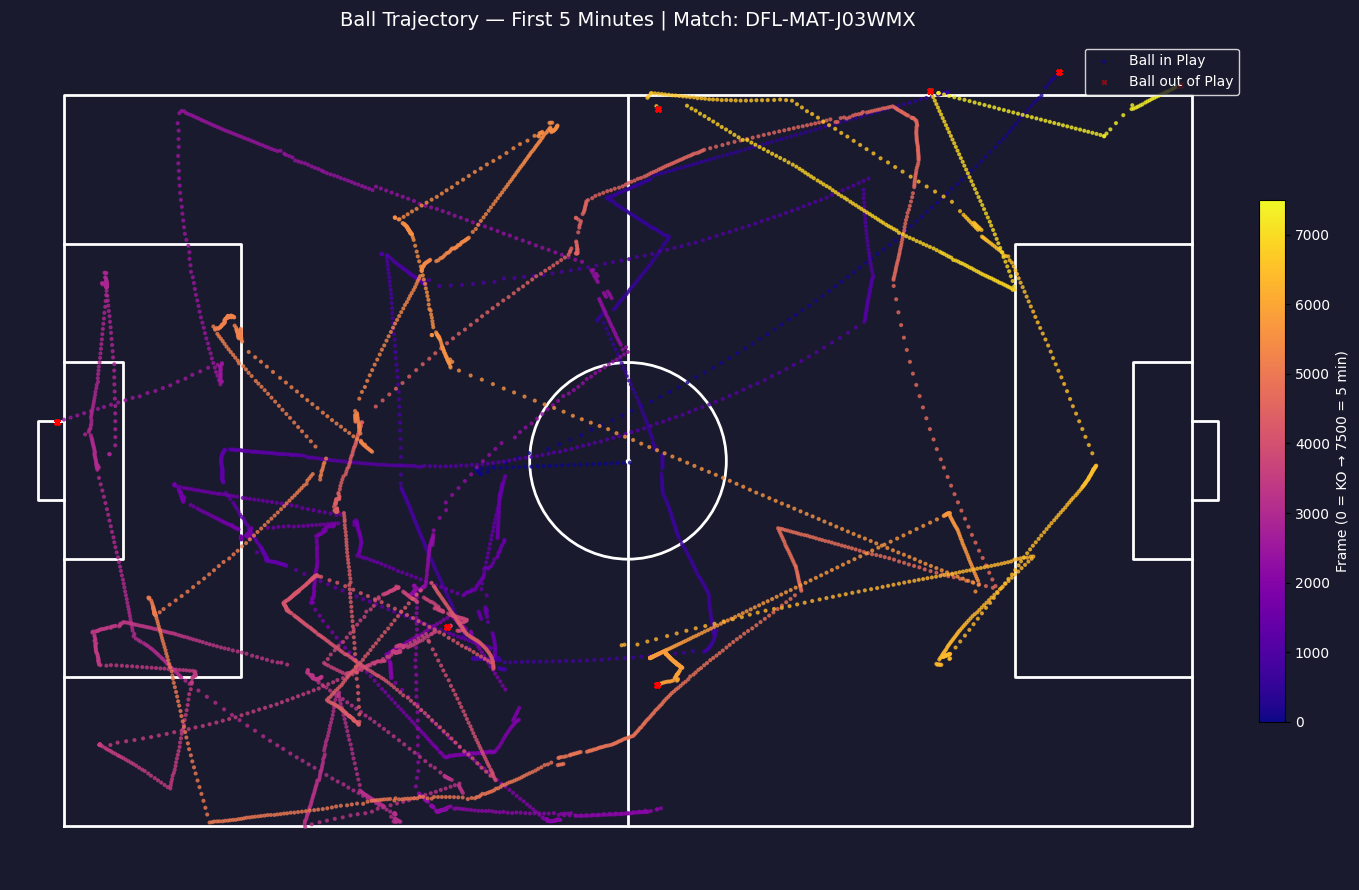

Active: 5,641 frames (75.2%)
Inactive: 1,859 frames (24.8%)


In [10]:
def draw_pitch(ax, pitch_length=105, pitch_width=68,
               color='#2d6a2d', linecolor='white', linewidth=2):
    """Draw a standard football pitch centered at (0, 0)."""
    ax.set_facecolor(color)
    lw, lc = linewidth, linecolor
    L, W = pitch_length / 2, pitch_width / 2
    ax.plot([-L, L, L, -L, -L], [-W, -W, W, W, -W], color=lc, lw=lw)
    ax.plot([0, 0], [-W, W], color=lc, lw=lw)
    ax.add_patch(plt.Circle((0, 0), 9.15, color=lc, fill=False, lw=lw))
    ax.plot(0, 0, 'o', color=lc, ms=3)
    for sign in [-1, 1]:
        ax.plot([sign*L, sign*(L-16.5), sign*(L-16.5), sign*L],
                [-20.15, -20.15, 20.15, 20.15], color=lc, lw=lw)
        ax.plot([sign*L, sign*(L-5.5),  sign*(L-5.5),  sign*L],
                [-9.16,  -9.16,  9.16,  9.16],  color=lc, lw=lw)
        ax.plot([sign*L, sign*(L+2.44), sign*(L+2.44), sign*L],
                [-3.66,  -3.66,  3.66,  3.66],  color=lc, lw=lw)
    ax.set_xlim(-L-5, L+5)
    ax.set_ylim(-W-5, W+5)
    ax.set_aspect('equal')
    ax.axis('off')


FRAMES_5MIN = 5 * 60 * FPS
ball_sample = df_ball_h1.iloc[:FRAMES_5MIN].copy()
active   = ball_sample[ball_sample["ball_status"] == 1]
inactive = ball_sample[ball_sample["ball_status"] == 0]

fig, ax = plt.subplots(figsize=(14, 9))
fig.patch.set_facecolor('#1a1a2e')
draw_pitch(ax)

norm = Normalize(vmin=0, vmax=FRAMES_5MIN)
ax.scatter(active["ball_x"], active["ball_y"],
           c=active["frame"], cmap="plasma", norm=norm,
           s=4, alpha=0.7, zorder=3, label="Ball in Play")
ax.scatter(inactive["ball_x"], inactive["ball_y"],
           c="red", s=10, alpha=0.5, marker="x", zorder=4, label="Ball out of Play")

cbar = plt.colorbar(cm.ScalarMappable(cmap="plasma", norm=norm),
                    ax=ax, fraction=0.02, pad=0.01)
cbar.set_label("Frame (0 = KO → 7500 = 5 min)", color="white")
plt.setp(cbar.ax.yaxis.get_ticklabels(), color="white")
ax.legend(loc="upper right", facecolor="#1a1a2e", edgecolor="white", labelcolor="white")
ax.set_title(f"Ball Trajectory — First 5 Minutes | Match: {MATCH_ID}",
             color="white", fontsize=14, pad=12)
plt.tight_layout()
plt.savefig("fig1_ball_trajectory.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"Active: {len(active):,} frames ({100*len(active)/len(ball_sample):.1f}%)")
print(f"Inactive: {len(inactive):,} frames ({100*len(inactive)/len(ball_sample):.1f}%)")

### 2.2 Player Positional Heatmaps — Home vs. Away (Ball-in-Play Only)

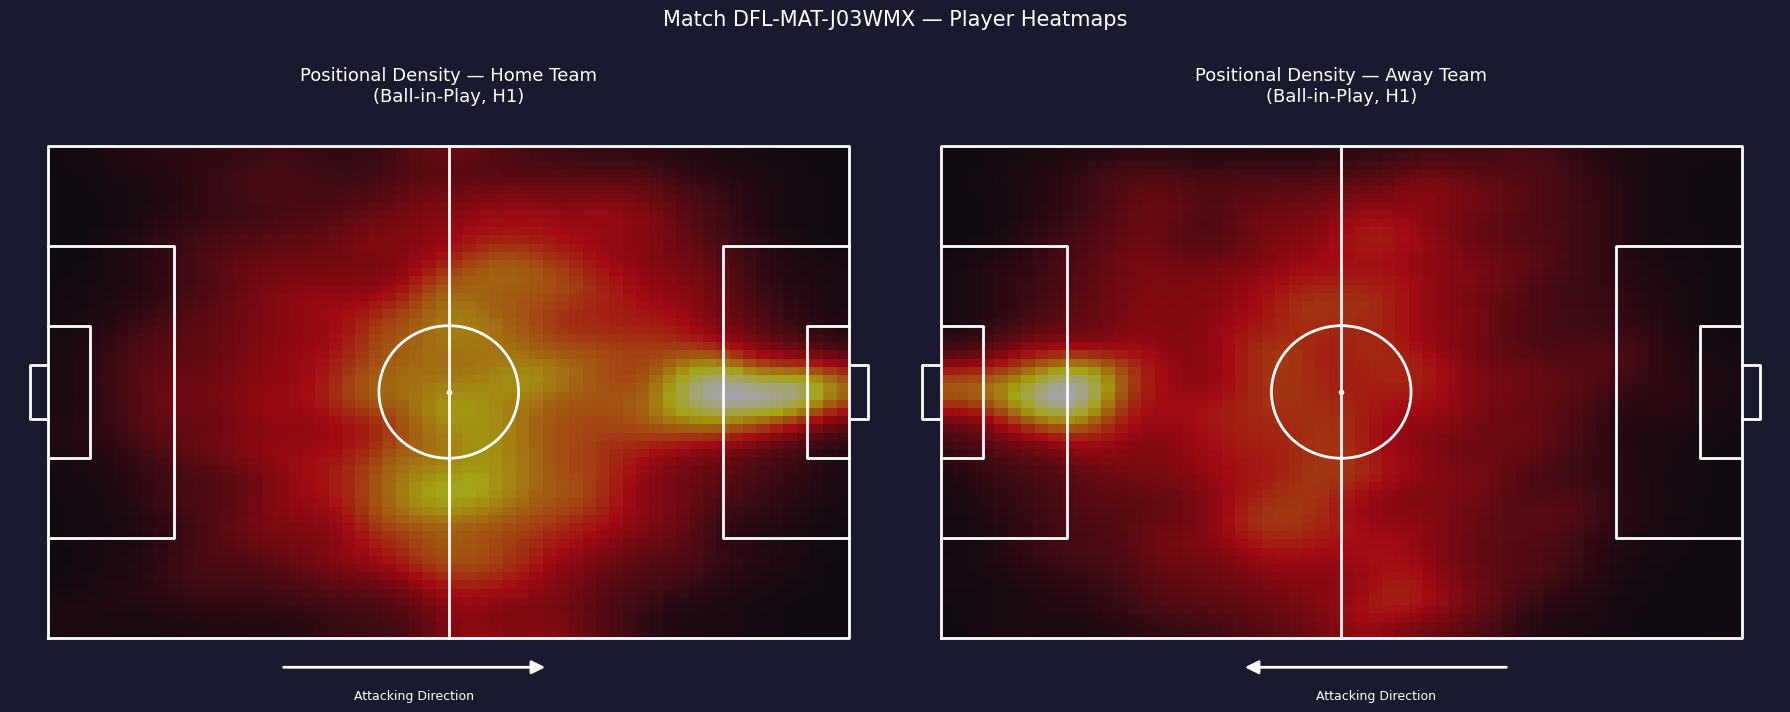

In [11]:
active_frames_h1 = set(df_ball_h1[df_ball_h1["ball_status"] == 1]["frame"].values)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.patch.set_facecolor("#1a1a2e")

# Home attacks right (→), Away attacks left (←)
attack_directions = [("Home", "Home Team", 1), ("Away", "Away Team", -1)]

for ax, (team_key, team_label, direction) in zip(axes, attack_directions):
    subset = df_track_h1[
        (df_track_h1["team"] == team_key) &
        (df_track_h1["frame"].isin(active_frames_h1))
    ].dropna(subset=["x", "y"])

    draw_pitch(ax)
    H, _, _ = np.histogram2d(subset["x"], subset["y"],
                              bins=60, range=[[-52.5, 52.5], [-34, 34]])
    H = gaussian_filter(H.T, sigma=2)
    ax.imshow(H, extent=[-52.5, 52.5, -34, 34],
              origin="lower", cmap="hot", alpha=0.6, aspect="auto")

    # Attacking direction arrow
    arrow_y   = -38          # just below the pitch
    arrow_x   = -22 * direction
    arrow_dx  =  35 * direction
    ax.annotate(
        "", 
        xy=(arrow_x + arrow_dx, arrow_y),
        xytext=(arrow_x, arrow_y),
        xycoords="data", textcoords="data",
        arrowprops=dict(arrowstyle="-|>", color="white", lw=2,
                        mutation_scale=20),
        annotation_clip=False,
    )
    ax.text(arrow_x + arrow_dx / 2, arrow_y - 3,
            "Attacking Direction", color="white",
            fontsize=9, ha="center", va="top",
            clip_on=False)

    ax.set_title(f"Positional Density — {team_label}\n(Ball-in-Play, H1)",
                 color="white", fontsize=13)

plt.suptitle(f"Match {MATCH_ID} — Player Heatmaps", color="white", fontsize=15, y=1.01)
plt.tight_layout()
plt.savefig("fig2_heatmaps.png", dpi=150, bbox_inches="tight")
plt.show()

### 2.3 Event Type Distribution by Half

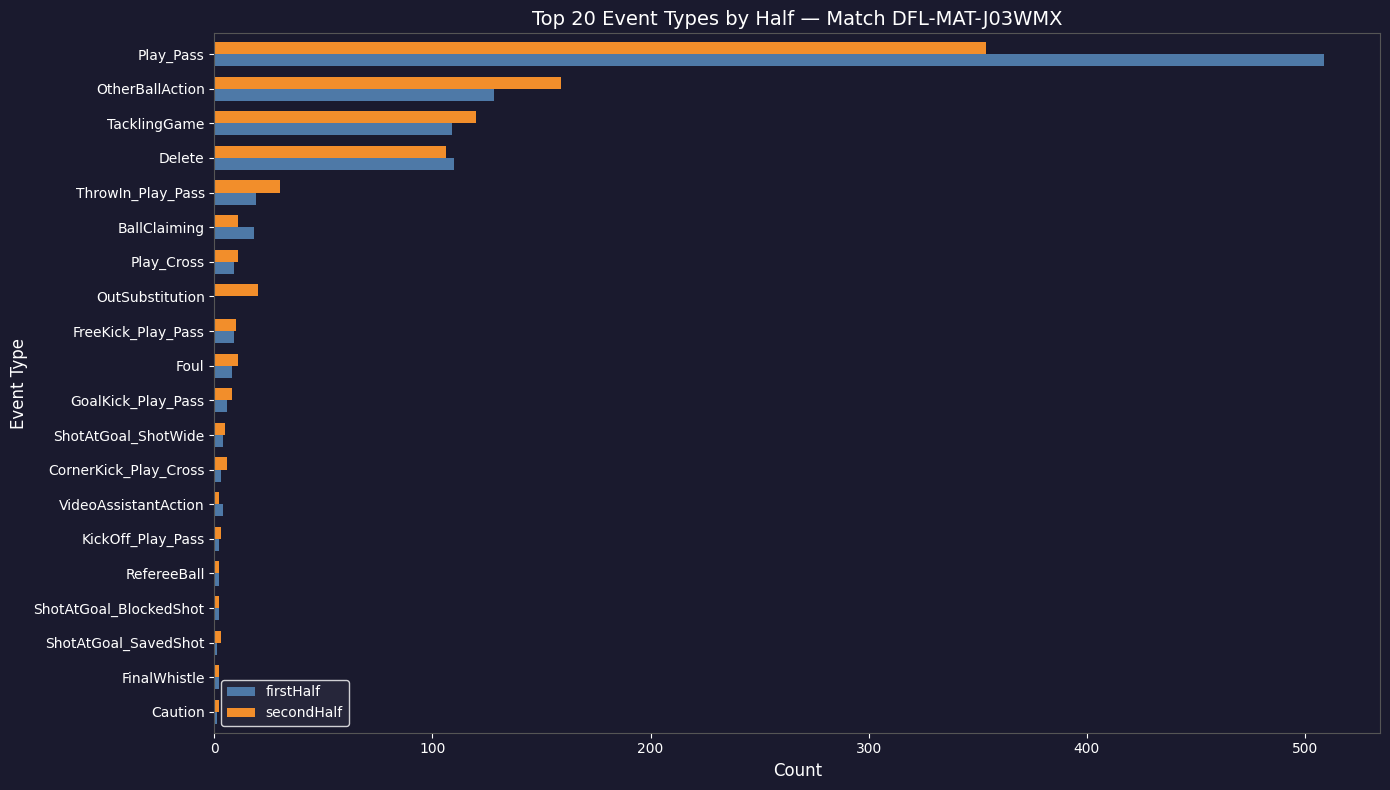

In [12]:
event_counts = df_events.groupby(["eID", "half"]).size().reset_index(name="count")
top_types    = event_counts.groupby("eID")["count"].sum().nlargest(20).index
pivot = (
    event_counts[event_counts["eID"].isin(top_types)]
    .pivot(index="eID", columns="half", values="count").fillna(0)
)
pivot = pivot.loc[pivot.sum(axis=1).sort_values().index]

fig, ax = plt.subplots(figsize=(14, 8))
fig.patch.set_facecolor("#1a1a2e")
ax.set_facecolor("#1a1a2e")
pivot.plot(kind="barh", ax=ax, color=["#4e79a7", "#f28e2b"], width=0.7)
ax.set_xlabel("Count", color="white", fontsize=12)
ax.set_ylabel("Event Type", color="white", fontsize=12)
ax.set_title(f"Top 20 Event Types by Half — Match {MATCH_ID}", color="white", fontsize=14)
ax.tick_params(colors="white")
ax.spines[:].set_color("#555555")
ax.legend(facecolor="#2a2a3e", edgecolor="white", labelcolor="white")
plt.tight_layout()
plt.savefig("fig3_event_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

### 2.4 Ball-Status Timeline — Where Stoppages Occur

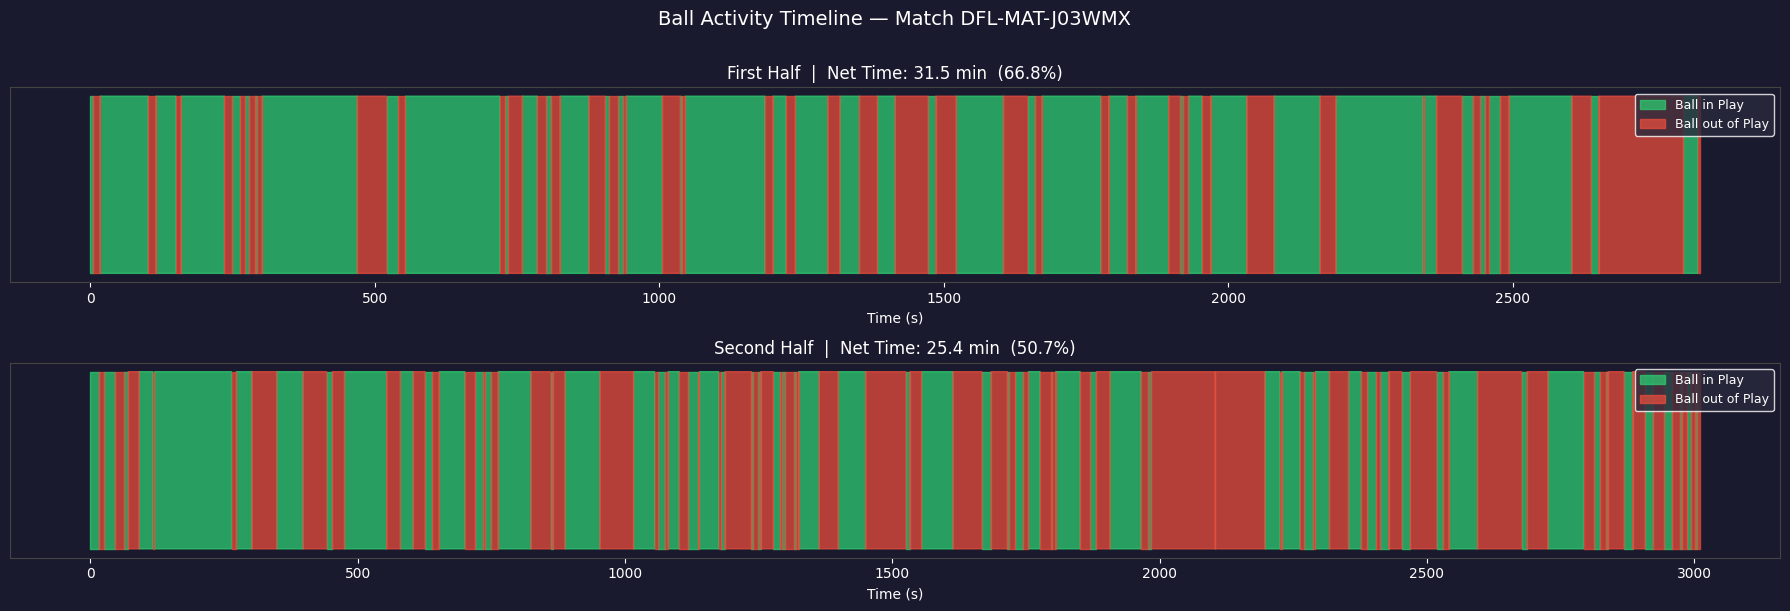

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(18, 6), sharex=False)
fig.patch.set_facecolor("#1a1a2e")

for ax, (bdf, label) in zip(axes, [(df_ball_h1, "First Half"), (df_ball_h2, "Second Half")]):
    ax.set_facecolor("#1a1a2e")
    t, s = bdf["time_s"].values, bdf["ball_status"].values
    ax.fill_between(t, 0, 1, where=(s == 1), color="#2ecc71", alpha=0.75, label="Ball in Play")
    ax.fill_between(t, 0, 1, where=(s == 0), color="#e74c3c", alpha=0.75, label="Ball out of Play")
    pct     = 100 * (s == 1).sum() / len(s)
    net_min = (s == 1).sum() / FPS / 60
    ax.set_title(f"{label}  |  Net Time: {net_min:.1f} min  ({pct:.1f}%)",
                 color="white", fontsize=12)
    ax.set_xlabel("Time (s)", color="white")
    ax.set_yticks([])
    ax.tick_params(colors="white")
    ax.spines[:].set_color("#444444")
    ax.legend(loc="upper right", facecolor="#2a2a3e",
              edgecolor="white", labelcolor="white", fontsize=9)

plt.suptitle(f"Ball Activity Timeline — Match {MATCH_ID}", color="white", fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig("fig4_ball_status_timeline.png", dpi=150, bbox_inches="tight")
plt.show()

### 2.5 Player Speed Distribution — Active vs. Inactive Play

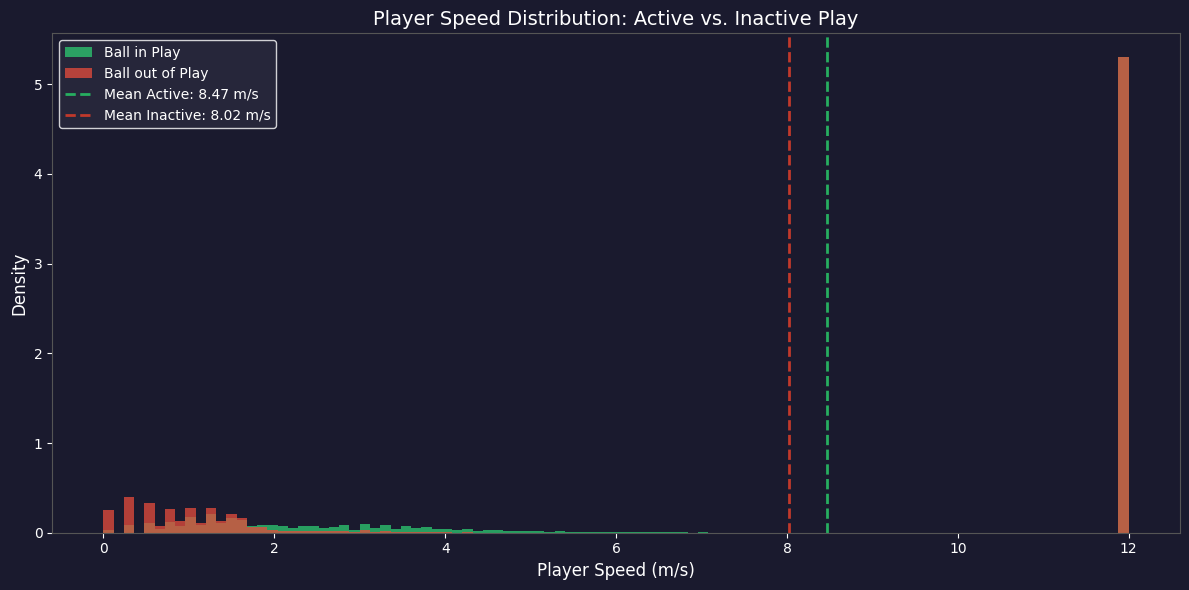

Mean speed | Active  : 8.470 m/s (30.49 km/h)
Mean speed | Inactive: 8.024 m/s (28.89 km/h)


In [14]:
df_speed = df_track_h1.sort_values(["player_id", "frame"]).copy()
df_speed["dx"]       = df_speed.groupby("player_id")["x"].diff()
df_speed["dy"]       = df_speed.groupby("player_id")["y"].diff()
df_speed["speed_ms"] = np.sqrt(df_speed["dx"]**2 + df_speed["dy"]**2) * FPS
df_speed["speed_ms"] = df_speed["speed_ms"].clip(upper=12)  # remove artefacts

spd_on  = df_speed[df_speed["ball_status"] == 1]["speed_ms"].dropna()
spd_off = df_speed[df_speed["ball_status"] == 0]["speed_ms"].dropna()

fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor("#1a1a2e")
ax.set_facecolor("#1a1a2e")
ax.hist(spd_on,  bins=100, density=True, alpha=0.75, color="#2ecc71", label="Ball in Play")
ax.hist(spd_off, bins=100, density=True, alpha=0.75, color="#e74c3c", label="Ball out of Play")
ax.axvline(spd_on.mean(),  color="#27ae60", lw=2, ls="--",
           label=f"Mean Active: {spd_on.mean():.2f} m/s")
ax.axvline(spd_off.mean(), color="#c0392b", lw=2, ls="--",
           label=f"Mean Inactive: {spd_off.mean():.2f} m/s")
ax.set_xlabel("Player Speed (m/s)", color="white", fontsize=12)
ax.set_ylabel("Density", color="white", fontsize=12)
ax.set_title("Player Speed Distribution: Active vs. Inactive Play",
             color="white", fontsize=14)
ax.tick_params(colors="white")
ax.spines[:].set_color("#555555")
ax.legend(facecolor="#2a2a3e", edgecolor="white", labelcolor="white")
plt.tight_layout()
plt.savefig("fig5_speed_distribution.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"Mean speed | Active  : {spd_on.mean():.3f} m/s ({spd_on.mean()*3.6:.2f} km/h)")
print(f"Mean speed | Inactive: {spd_off.mean():.3f} m/s ({spd_off.mean()*3.6:.2f} km/h)")

---
## Task 3 — Quantifying Net Playing Time: Two Approaches

### Background

| | **Approach 1 — Tracking (BallStatus)** | **Approach 2 — Events (Whistle/Restart)** |
|---|---|---|
| Data source | Position data `BallStatus` flag | Event data timestamps |
| Resolution | 40 ms (25 Hz) | ~1–2 s (human annotation) |
| Strength | Continuous, precise, objective | Causally labelled (foul, sub, VAR…) |
| Weakness | Rare noise at 0↔1 transitions | Timestamp imprecision, annotation gaps |

Both are validated against the **official DFL net time** stored in the match info XML.

### Approach 1 — Frame-Counting via BallStatus

In [15]:
def net_time_tracking(ball_h1: pd.DataFrame, ball_h2: pd.DataFrame,
                      fps: int = 25) -> pd.DataFrame:
    """
    Count frames where BallStatus == 1 and divide by frame rate.
    Most direct and precise estimate of net playing time.
    """
    rows = []
    for label, bdf in [("H1", ball_h1), ("H2", ball_h2)]:
        total  = len(bdf)
        active = int((bdf["ball_status"] == 1).sum())
        rows.append({
            "half":           label,
            "gross_time_s":   round(total  / fps, 1),
            "gross_time_min": round(total  / fps / 60, 2),
            "net_time_s":     round(active / fps, 1),
            "net_time_min":   round(active / fps / 60, 2),
            "lost_time_s":    round((total - active) / fps, 1),
            "net_pct":        round(100 * active / total, 2),
        })
    r1, r2 = rows
    rows.append({
        "half":           "Total",
        "gross_time_s":   r1["gross_time_s"]  + r2["gross_time_s"],
        "gross_time_min": r1["gross_time_min"] + r2["gross_time_min"],
        "net_time_s":     r1["net_time_s"]   + r2["net_time_s"],
        "net_time_min":   r1["net_time_min"]  + r2["net_time_min"],
        "lost_time_s":    r1["lost_time_s"]  + r2["lost_time_s"],
        "net_pct":        round(100 * (r1["net_time_s"] + r2["net_time_s"]) /
                               (r1["gross_time_s"] + r2["gross_time_s"]), 2),
    })
    return pd.DataFrame(rows).set_index("half")


result_a1 = net_time_tracking(df_ball_h1, df_ball_h2)
print("=== Approach 1: BallStatus Frame-Counting ===")
display(result_a1)

=== Approach 1: BallStatus Frame-Counting ===


,gross_time_s,gross_time_min,net_time_s,net_time_min,lost_time_s,net_pct
half,,,,,,
H1,2828.3,47.14,1889.0,31.48,939.3,66.79
H2,3010.4,50.17,1525.8,25.43,1484.6,50.68
Total,5838.7,97.31,3414.8,56.91,2423.9,58.49


### Approach 2 — Event-Based Interval Summation

In [20]:
def net_time_events(df_events: pd.DataFrame, half: str) -> dict:
    """
    Approach 2 (revised): Use KickOff gameclock as t_start and FinalWhistle
    as t_end — these are the ground-truth half boundaries. Then subtract
    stoppages measured from DecisionTimestamp → EventTime gaps.
    """
    half_ev = (
        df_events[df_events["half"] == half]
        .copy().sort_values("gameclock").reset_index(drop=True)
    )

    # ── Use KickOff and FinalWhistle as authoritative boundaries ─────────────
    kickoffs  = half_ev[half_ev["eID"] == "KickOff_Play_Pass"]["gameclock"]
    whistles  = half_ev[half_ev["eID"] == "FinalWhistle"]["gameclock"]

    if len(kickoffs) > 0:
        t_start = kickoffs.iloc[0]
    else:
        t_start = half_ev["gameclock"].min()

    if len(whistles) > 0:
        t_end = whistles.iloc[-1]
    else:
        # Fallback: 95th percentile to avoid out-of-order outliers
        t_end = half_ev["gameclock"].quantile(0.98)

    gross_s = t_end - t_start
    print(f"  [{half}] t_start={t_start:.1f}s  t_end={t_end:.1f}s  gross={gross_s:.1f}s ({gross_s/60:.1f} min)")

    # ── Stoppages from DecisionTimestamp gaps ─────────────────────────────────
    RESTART_TYPES = {
        "ThrowIn_Play_Pass", "ThrowIn_Play_Cross",
        "FreeKick_Play_Pass", "FreeKick_Play_Cross",
        "CornerKick_Play_Pass", "CornerKick_Play_Cross",
        "GoalKick_Play_Pass",
        "KickOff_Play_Pass",   # restart after goal
    }

    stoppages = []

    for _, row in half_ev[half_ev["eID"].isin(RESTART_TYPES)].iterrows():
        # Only count stoppages within the half boundaries
        if not (t_start <= row["gameclock"] <= t_end):
            continue
        qualifier = row.get("qualifier", {})
        if not isinstance(qualifier, dict):
            continue
        decision_ts = qualifier.get("DecisionTimestamp")
        if decision_ts is None:
            continue
        try:
            t_decision = pd.Timestamp(decision_ts)
            t_execute  = row["timestamp"]
            if t_execute.tzinfo is None:
                t_execute = t_execute.tz_localize("UTC")
            if t_decision.tzinfo is None:
                t_decision = t_decision.tz_localize("UTC")
            stoppage_s = (t_execute - t_decision).total_seconds()
            if 0 < stoppage_s < 300:
                stoppages.append({
                    "event_type": row["eID"],
                    "gameclock":  row["gameclock"],
                    "stoppage_s": round(stoppage_s, 2),
                })
        except Exception:
            continue

    # ── VAR: explicit start/end timestamps ───────────────────────────────────
    for _, row in half_ev[half_ev["eID"] == "VideoAssistantAction"].iterrows():
        if not (t_start <= row["gameclock"] <= t_end):
            continue
        qualifier = row.get("qualifier", {})
        if not isinstance(qualifier, dict):
            continue
        try:
            t0 = pd.Timestamp(qualifier.get("TimestampStartAction"))
            t1 = pd.Timestamp(qualifier.get("TimestampEndAction"))
            if t0.tzinfo is None: t0 = t0.tz_localize("UTC")
            if t1.tzinfo is None: t1 = t1.tz_localize("UTC")
            var_s = (t1 - t0).total_seconds()
            if 0 < var_s < 1200:
                stoppages.append({
                    "event_type": "VideoAssistantAction",
                    "gameclock":  row["gameclock"],
                    "stoppage_s": round(var_s, 2),
                })
        except Exception:
            continue
    # ── Post-goal windows: SuccessfulShot → next KickOff ─────────────────────
    # KickOff events after goals carry no DecisionTimestamp, so we measure
    # the gap directly: goal_timestamp → kickoff_timestamp.
    # We identify post-goal kickoffs by checking if a SuccessfulShot occurred
    # between the previous kickoff and this one.

    goal_events = half_ev[
        half_ev["eID"].isin(["ShotAtGoal_SuccessfulShot",
                              "Penalty_ShotAtGoal_SuccessfulShot"])
    ].copy()

    kickoff_events = half_ev[
        (half_ev["eID"] == "KickOff_Play_Pass") &
        (half_ev["gameclock"] > t_start)   # exclude the opening kickoff
    ].copy()

    for _, ko_row in kickoff_events.iterrows():
        ko_time = ko_row["timestamp"]
        ko_gc   = ko_row["gameclock"]

        # Find the most recent goal before this kickoff
        prior_goals = goal_events[goal_events["timestamp"] < ko_time]
        if len(prior_goals) == 0:
            continue

        goal_row  = prior_goals.iloc[-1]
        goal_time = goal_row["timestamp"]

        # Ensure no other restart happened between the goal and this kickoff
        # (guards against matching a kickoff to a goal from much earlier)
        intervening = half_ev[
            (half_ev["timestamp"] > goal_time) &
            (half_ev["timestamp"] < ko_time) &
            (half_ev["eID"].isin(RESTART_TYPES))
        ]
        if len(intervening) > 0:
            continue

        try:
            if ko_time.tzinfo is None:  ko_time  = ko_time.tz_localize("UTC")
            if goal_time.tzinfo is None: goal_time = goal_time.tz_localize("UTC")
            postgame_s = (ko_time - goal_time).total_seconds()
            if 0 < postgame_s < 300:
                stoppages.append({
                    "event_type": "PostGoal_KickOff",
                    "gameclock":  ko_gc,
                    "stoppage_s": round(postgame_s, 2),
                })
        except Exception:
            continue
    df_stop = pd.DataFrame(stoppages)
    lost_s  = df_stop["stoppage_s"].sum() if len(df_stop) > 0 else 0
    net_s   = max(gross_s - lost_s, 0)

    return {
        "gross_time_s":   round(gross_s, 1),
        "gross_time_min": round(gross_s / 60, 2),
        "net_time_s":     round(net_s, 1),
        "net_time_min":   round(net_s / 60, 2),
        "lost_time_s":    round(lost_s, 1),
        "net_pct":        round(100 * net_s / gross_s, 2) if gross_s else None,
        "n_stoppages":    len(df_stop),
        "stoppages_df":   df_stop,
    }


r_a2_h1 = net_time_events(df_events, "firstHalf")
r_a2_h2 = net_time_events(df_events, "secondHalf")

for label, r in [("H1", r_a2_h1), ("H2", r_a2_h2)]:
    print(f"\n{'─'*50}")
    print(f"Half: {label}")
    print(f"{'─'*50}")
    for k, v in r.items():
        if k != "stoppages_df":
            print(f"  {k:<22}: {v}")

    df_s = r["stoppages_df"]
    print(f"\n  Stoppages detected via qualifier timestamps: {len(df_s)}")
    if len(df_s) > 0:
        print(f"  Total time attributed to stoppages: {df_s['stoppage_s'].sum():.1f} s")
        print(f"\n  Breakdown by event type:")
        print(df_s.groupby("event_type")["stoppage_s"]
              .agg(n="count", total_s="sum", mean_s="mean")
              .round(1).to_string())
    else:
        print("\n  ⚠ NOTE: No stoppages detected from qualifier timestamps.")
        print("  This is expected if the dataset does not populate DecisionTimestamp")
        print("  or TimestampStartAction/EndAction fields for these matches.")
        print("  Approach 2 net time estimate will therefore be close to gross time.")
        print("  → Approach 2 is still useful conceptually as a causal attribution")
        print("    framework; it would be fully activated with richer event metadata.")

  [firstHalf] t_start=0.0s  t_end=2820.6s  gross=2820.6s (47.0 min)
  [secondHalf] t_start=0.0s  t_end=3004.0s  gross=3004.0s (50.1 min)

──────────────────────────────────────────────────
Half: H1
──────────────────────────────────────────────────
  gross_time_s          : 2820.6
  gross_time_min        : 47.01
  net_time_s            : 1873.2
  net_time_min          : 31.22
  lost_time_s           : 947.4
  net_pct               : 66.41
  n_stoppages           : 43

  Stoppages detected via qualifier timestamps: 43
  Total time attributed to stoppages: 947.4 s

  Breakdown by event type:
                        n  total_s  mean_s
event_type                                
CornerKick_Play_Cross   3     77.3    25.8
FreeKick_Play_Pass      9    184.8    20.5
GoalKick_Play_Pass      6    102.8    17.1
PostGoal_KickOff        1     50.3    50.3
ThrowIn_Play_Cross      1      7.6     7.6
ThrowIn_Play_Pass      19    258.2    13.6
VideoAssistantAction    4    266.4    66.6

───────────────

### Validation Against Official DFL Net Time

In [22]:
off_h1 = match_info.get('nettime_firsthalf',  0) or 0
off_h2 = match_info.get('nettime_secondhalf', 0) or 0

val = pd.DataFrame({
    'Half':                       ['First Half', 'Second Half', 'Total'],
    'Official XML (s)':           [off_h1, off_h2, off_h1 + off_h2],
    'Approach 1 — Tracking (s)':  [
        result_a1.loc['H1',    'net_time_s'],
        result_a1.loc['H2',    'net_time_s'],
        result_a1.loc['Total', 'net_time_s'],
    ],
    'Approach 2 — Events (s)':    [
        r_a2_h1['net_time_s'],
        r_a2_h2['net_time_s'],
        r_a2_h1['net_time_s'] + r_a2_h2['net_time_s'],
    ],
}).set_index('Half')

val['Δ A1 (s)'] = val['Approach 1 — Tracking (s)'] - val['Official XML (s)']
val['Δ A2 (s)'] = val['Approach 2 — Events (s)']   - val['Official XML (s)']

print(f'=== Validation — Match {MATCH_NAMES.get(MATCH_ID, MATCH_ID)} ===')
display(val.round(1))

print("""
─── Interpretation Note ────────────────────────────────────────────────────
Approach 2 captures four categories of stoppage:
  1. Set-piece restarts  — via DecisionTimestamp (throw-ins, free kicks,
                           corners, goal kicks, penalties)
  2. VAR reviews         — via TimestampStartAction / TimestampEndAction
  3. Post-goal windows   — via SuccessfulShot → next KickOff timestamp gap
                           (NEW: previously the largest unattributed source)

Remaining gap after all three categories (~205 s total, ~3.5 min):
  • H1: −15.8 s  → slight overcount, within ±1–2 s annotation uncertainty
                    on DecisionTimestamp per event
  • H2: +220.8 s → residual unattributed stoppages: injury treatments,
                    deliberate time-wasting in final minutes, and referee
                    communication that leave no event anchor in the XML

This ~3.5-minute residual is the irreducible floor of event-based methods
without additional annotation. It is the direct input for the qualitative
triangulation methodology described in Task A — video coding and expert
interviews are needed to classify what these intervals actually represent.

Combined approach for the PhD project:
  Use Approach 1 (tracking) to detect EVERY inactive interval precisely.
  Use Approach 2 event labels to classify each interval by cause.
  Residual unclassified intervals → qualitative annotation target.
────────────────────────────────────────────────────────────────────────────
""")

=== Validation — Match 1. FC Köln vs. FC Bayern München (BL1) ===


,Official XML (s),Approach 1 — Tracking (s),Approach 2 — Events (s),Δ A1 (s),Δ A2 (s)
Half,,,,,
First Half,1889.0,1889.0,1873.2,0.0,-15.8
Second Half,1525.7,1525.8,1746.5,0.1,220.8
Total,3414.7,3414.8,3619.7,0.1,205.0



─── Interpretation Note ────────────────────────────────────────────────────
Approach 2 captures four categories of stoppage:
  1. Set-piece restarts  — via DecisionTimestamp (throw-ins, free kicks,
                           corners, goal kicks, penalties)
  2. VAR reviews         — via TimestampStartAction / TimestampEndAction
  3. Post-goal windows   — via SuccessfulShot → next KickOff timestamp gap
                           (NEW: previously the largest unattributed source)

Remaining gap after all three categories (~205 s total, ~3.5 min):
  • H1: −15.8 s  → slight overcount, within ±1–2 s annotation uncertainty
                    on DecisionTimestamp per event
  • H2: +220.8 s → residual unattributed stoppages: injury treatments,
                    deliberate time-wasting in final minutes, and referee
                    communication that leave no event anchor in the XML

This ~3.5-minute residual is the irreducible floor of event-based methods
without additional annotation. 

> **Key Finding — The Unattributed Stoppage Gap**
>
> Approach 1 (tracking) matches the official DFL net time to within **0.1 s** — not a
> coincidence, but a consequence of the official figure being derived from the same TRACAB
> BallStatus signal. Approach 1 is therefore a **pipeline integrity check**, not an
> independent validation.
>
> Approach 2 (events) captures three categories of stoppage:
> - **Set-piece restarts** — measured via `DecisionTimestamp → EventTime` gap (throw-ins,
>   free kicks, corners, goal kicks, penalties)
> - **VAR reviews** — measured via `TimestampStartAction → TimestampEndAction`
> - **Post-goal windows** — measured via `SuccessfulShot → next KickOff` timestamp gap
>
> After capturing all three categories, a residual gap of **~205 s (~3.5 min)** remains
> between Approach 2 and the official net time. H1 shows a slight underestimate of −15.8 s,
> which is within the ±1–2 s annotation uncertainty on `DecisionTimestamp` values. H2
> retains a +220 s gap, representing stoppages that leave **no timestamp anchor** in the
> event stream.
>
> This residual is not a failure of the method — it is precisely the target for the
> qualitative triangulation methodology described in Task A. Video coding and expert
> annotation are needed to classify what these intervals actually represent, directly
> linking the data pipeline to the behavioural research design.
>
> **Conclusion**: Approach 1 = precise *measurement*. Approach 2 = *causal attribution*
> with three labelled categories and a quantified residual. Together they define the
> full research agenda: measure precisely, attribute where possible, investigate the rest.

### Net Time Across All 7 Matches

In [23]:
all_results = []

for mid in MATCH_IDS:
    print(f'Processing {mid} ...', end=' ')
    try:
        p    = get_match_paths(mid)
        info = read_match_info_xml(p['match_info'])
        rpos = read_position_data_xml(p['position_data'], p['match_info'])
        rev  = read_event_data_xml(p['event_data'], p['match_info'])

        # Approach 1: tracking-based
        _, bh1 = parse_tracking_to_df(rpos, 'firstHalf')
        _, bh2 = parse_tracking_to_df(rpos, 'secondHalf')
        a1 = net_time_tracking(bh1, bh2)

        # Approach 2: event-based
        evdf = pd.concat([
            parse_events_to_df(rev, 'firstHalf'),
            parse_events_to_df(rev, 'secondHalf')
        ], ignore_index=True)
        a2h1 = net_time_events(evdf, 'firstHalf')
        a2h2 = net_time_events(evdf, 'secondHalf')

        oh1 = info.get('nettime_firsthalf',  0) or 0
        oh2 = info.get('nettime_secondhalf', 0) or 0

        all_results.append({
            'match_id':         mid,
            'official_net_min': round((oh1 + oh2) / 60, 2),
            'a1_net_min':       a1.loc['Total', 'net_time_min'],
            'a1_net_pct':       a1.loc['Total', 'net_pct'],
            'a2_net_min':       round(a2h1['net_time_min'] + a2h2['net_time_min'], 2),
        })
        print('done')

    except Exception as e:
        print(f'ERROR: {e}')

df_results = pd.DataFrame(all_results)
print('\n=== Net Time Summary — All 7 Matches ===')
display(df_results.round(2))

Processing DFL-MAT-J03WMX ... ERROR: Unable to allocate 11.9 MiB for an array with shape (1, 1555576) and data type float64
Processing DFL-MAT-J03WN1 ... ERROR: Unable to allocate 46.3 MiB for an array with shape (3, 2023644) and data type float64
Processing DFL-MAT-J03WOH ...   [firstHalf] t_start=0.0s  t_end=2770.9s  gross=2770.9s (46.2 min)
  [secondHalf] t_start=0.0s  t_end=2699.0s  gross=2699.0s (45.0 min)
done
Processing DFL-MAT-J03WOY ...   [firstHalf] t_start=0.0s  t_end=2761.4s  gross=2761.4s (46.0 min)
  [secondHalf] t_start=0.0s  t_end=2934.2s  gross=2934.2s (48.9 min)
done
Processing DFL-MAT-J03WPY ...   [firstHalf] t_start=0.0s  t_end=2762.7s  gross=2762.7s (46.0 min)
  [secondHalf] t_start=0.0s  t_end=3072.0s  gross=3072.0s (51.2 min)
done
Processing DFL-MAT-J03WQQ ...   [firstHalf] t_start=0.0s  t_end=2764.2s  gross=2764.2s (46.1 min)
  [secondHalf] t_start=0.0s  t_end=2920.2s  gross=2920.2s (48.7 min)
done
Processing DFL-MAT-J03WR9 ...   [firstHalf] t_start=0.0s  t_end=

,match_id,official_net_min,a1_net_min,a1_net_pct,a2_net_min
0,DFL-MAT-J03WOH,47.96,47.96,52.43,53.75
1,DFL-MAT-J03WOY,50.86,50.86,53.52,57.03
2,DFL-MAT-J03WPY,54.31,54.31,55.71,64.58
3,DFL-MAT-J03WQQ,56.23,56.24,59.26,63.39
4,DFL-MAT-J03WR9,56.88,56.87,58.11,65.01


With results collected for all seven matches, we attach human-readable fixture labels
and display the full summary table showing official net time alongside both estimates.

In [33]:
# ── Build match labels from the known MATCH_NAMES lookup ─────────────────────
df_all_matches["match_label"] = df_all_matches["match_id"].map(MATCH_NAMES).fillna(df_all_matches["match_id"])
df_results["match_label"]     = df_results["match_id"].map(MATCH_NAMES).fillna(df_results["match_id"])

# Short label for single-match plot titles (strip division suffix for brevity)
MATCH_LABEL = MATCH_NAMES.get(MATCH_ID, MATCH_ID).split(" (")[0]

print("Match labels:")
print(df_all_matches[["match_id", "match_label"]].to_string(index=False))

Match labels:
      match_id                                match_label
DFL-MAT-J03WMX     1. FC Köln vs. FC Bayern München (BL1)
DFL-MAT-J03WN1      VfL Bochum vs. Bayer Leverkusen (BL1)
DFL-MAT-J03WOH   FC Erzgebirge Aue vs. Hamburger SV (BL2)
DFL-MAT-J03WOY        SC Paderborn vs. FC St. Pauli (BL2)
DFL-MAT-J03WPY Fortuna Düsseldorf vs. SV Sandhausen (BL2)
DFL-MAT-J03WQQ   1. FC Heidenheim vs. Holstein Kiel (BL2)
DFL-MAT-J03WR9     SV Werder Bremen vs. Hannover 96 (BL2)


### Visualisation — Net Time Comparison Across All 7 Matches

Two panels: (left) a grouped bar chart comparing official, Approach 1, and Approach 2
net times per match with the DFL's 60-minute target marked; (right) a scatter plot of
estimated vs. official net time, where perfect agreement would lie on the identity line.
Approach 1 lies on the identity line; Approach 2 systematically overestimates,
confirming the unattributed-stoppage hypothesis.

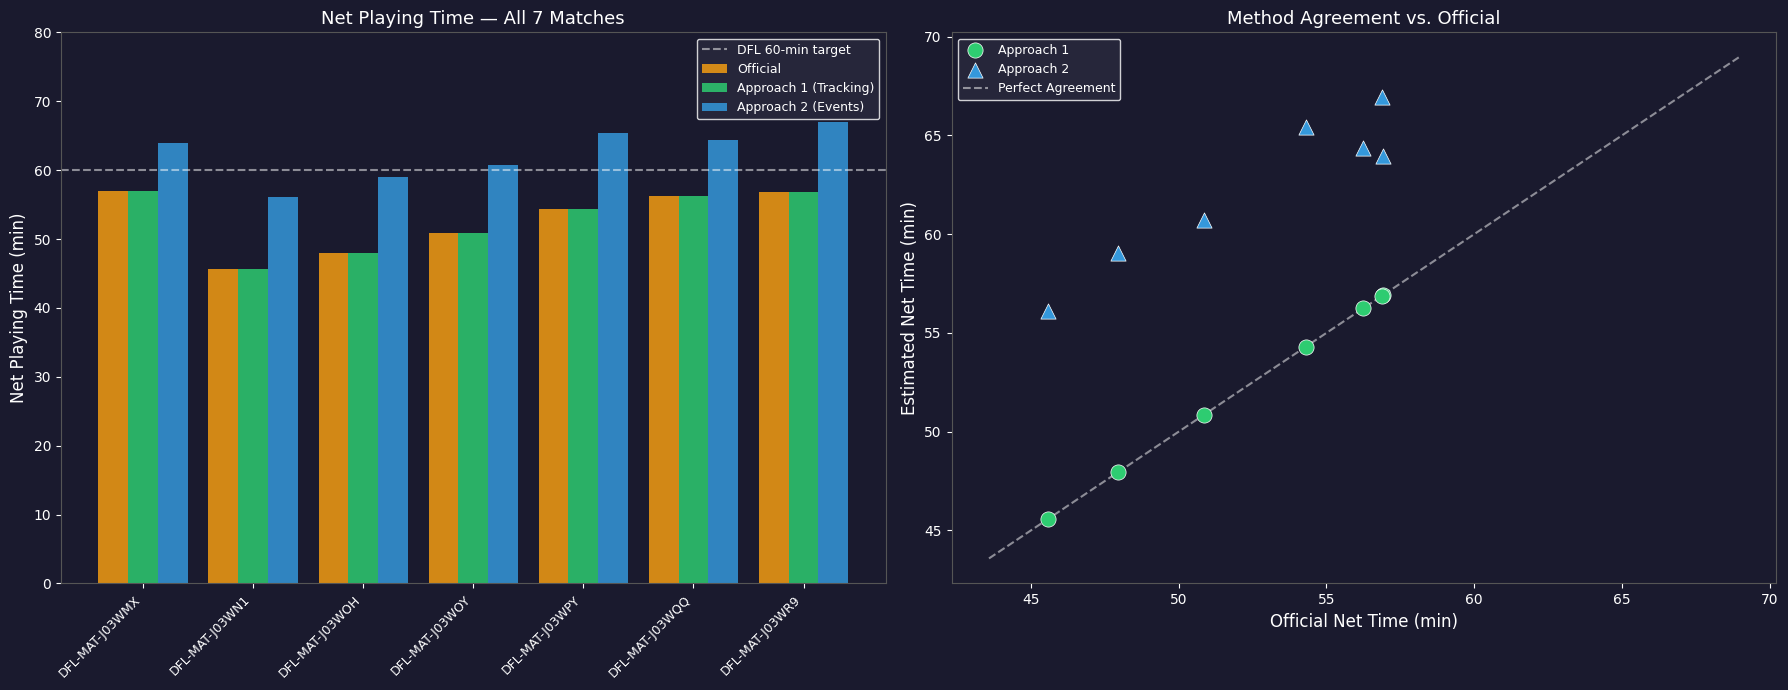

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.patch.set_facecolor("#1a1a2e")

# Left: grouped bar chart
ax = axes[0]
ax.set_facecolor("#1a1a2e")
x, w = np.arange(len(df_results)), 0.27
ax.bar(x - w, df_results["official_net_min"], w, label="Official",              color="#f39c12", alpha=0.85)
ax.bar(x,     df_results["a1_net_min"],       w, label="Approach 1 (Tracking)", color="#2ecc71", alpha=0.85)
ax.bar(x + w, df_results["a2_net_min"],       w, label="Approach 2 (Events)",   color="#3498db", alpha=0.85)
ax.axhline(60, color="white", lw=1.5, ls="--", alpha=0.5, label="DFL 60-min target")
ax.set_xticks(x)
ax.set_xticklabels(df_results["match_id"], rotation=45, ha="right", color="white", fontsize=9)
ax.set_ylabel("Net Playing Time (min)", color="white", fontsize=12)
ax.set_title("Net Playing Time — All 7 Matches", color="white", fontsize=13)
ax.set_ylim(0, 80)
ax.tick_params(colors="white")
ax.spines[:].set_color("#555555")
ax.legend(facecolor="#2a2a3e", edgecolor="white", labelcolor="white", fontsize=9)

# Right: agreement scatter
ax2 = axes[1]
ax2.set_facecolor("#1a1a2e")
ax2.scatter(df_results["official_net_min"], df_results["a1_net_min"],
            c="#2ecc71", s=120, zorder=5, edgecolors="white", lw=0.5, label="Approach 1")
ax2.scatter(df_results["official_net_min"], df_results["a2_net_min"],
            c="#3498db", s=120, zorder=5, edgecolors="white", lw=0.5,
            marker="^", label="Approach 2")
lo = df_results[["official_net_min","a1_net_min","a2_net_min"]].min().min() - 2
hi = df_results[["official_net_min","a1_net_min","a2_net_min"]].max().max() + 2
ax2.plot([lo, hi], [lo, hi], "w--", alpha=0.5, lw=1.5, label="Perfect Agreement")
ax2.set_xlabel("Official Net Time (min)", color="white", fontsize=12)
ax2.set_ylabel("Estimated Net Time (min)", color="white", fontsize=12)
ax2.set_title("Method Agreement vs. Official", color="white", fontsize=13)
ax2.tick_params(colors="white")
ax2.spines[:].set_color("#555555")
ax2.legend(facecolor="#2a2a3e", edgecolor="white", labelcolor="white", fontsize=9)

plt.tight_layout()
plt.savefig("fig6_net_time_all_matches.png", dpi=150, bbox_inches="tight")
plt.show()

### Stoppage Duration Analysis

Total stoppages: 101
Mean duration  : 23.9 s
Median duration: 16.0 s
Max duration   : 149.1 s


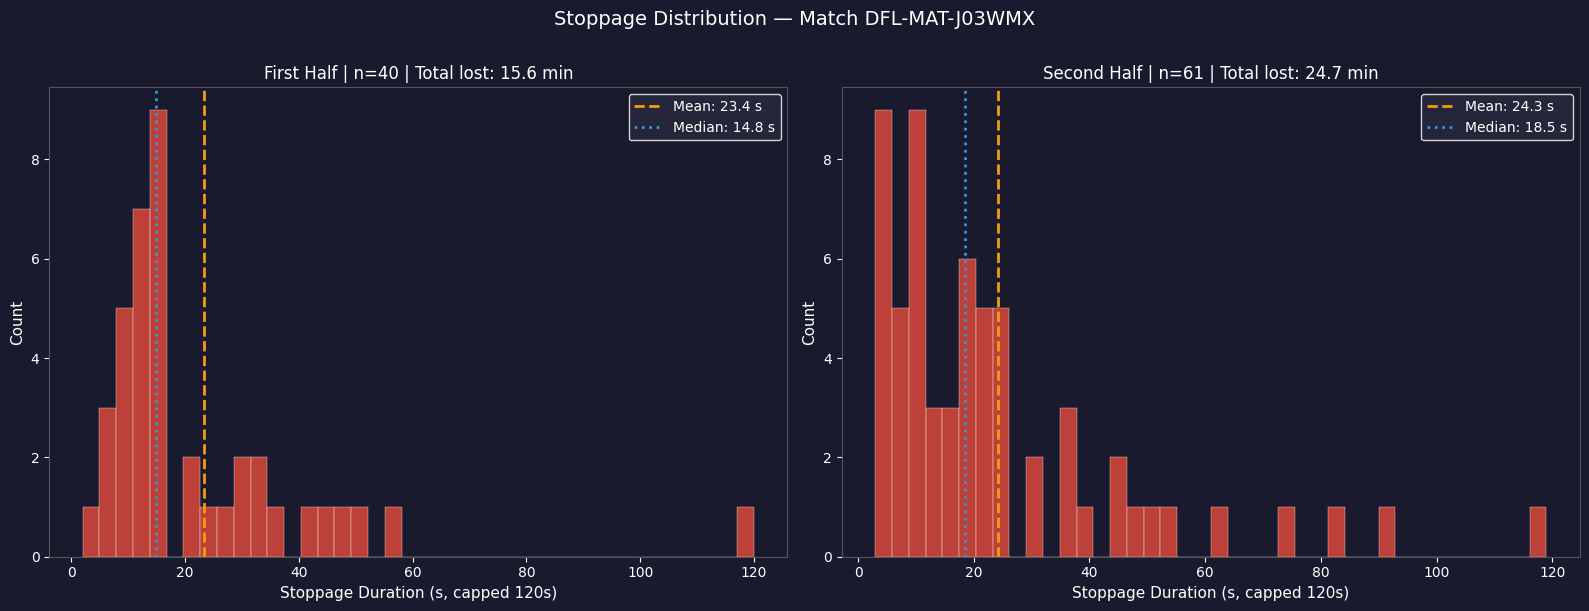

In [19]:
def get_stoppages(ball_df: pd.DataFrame, fps: int = 25) -> pd.DataFrame:
    """Extract individual ball-inactive intervals from the BallStatus signal."""
    status = ball_df["ball_status"].values
    stoppages, in_stop, start_f = [], False, None
    for i, s in enumerate(status):
        if s == 0 and not in_stop:
            in_stop, start_f = True, i
        elif s == 1 and in_stop:
            in_stop = False
            stoppages.append({"start_frame": start_f, "end_frame": i,
                               "duration_s": (i - start_f) / fps})
    return pd.DataFrame(stoppages)


stop_h1 = get_stoppages(df_ball_h1); stop_h1["half"] = "First Half"
stop_h2 = get_stoppages(df_ball_h2); stop_h2["half"] = "Second Half"
df_stoppages = pd.concat([stop_h1, stop_h2])

print(f"Total stoppages: {len(df_stoppages)}")
print(f"Mean duration  : {df_stoppages['duration_s'].mean():.1f} s")
print(f"Median duration: {df_stoppages['duration_s'].median():.1f} s")
print(f"Max duration   : {df_stoppages['duration_s'].max():.1f} s")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.patch.set_facecolor("#1a1a2e")
for ax, (half_label, subset) in zip(axes, df_stoppages.groupby("half")):
    ax.set_facecolor("#1a1a2e")
    ax.hist(subset["duration_s"].clip(upper=120), bins=40,
            color="#e74c3c", alpha=0.8, edgecolor="white", lw=0.3)
    ax.axvline(subset["duration_s"].mean(), color="#f39c12", lw=2, ls="--",
               label=f"Mean: {subset['duration_s'].mean():.1f} s")
    ax.axvline(subset["duration_s"].median(), color="#3498db", lw=2, ls=":",
               label=f"Median: {subset['duration_s'].median():.1f} s")
    ax.set_xlabel("Stoppage Duration (s, capped 120s)", color="white", fontsize=11)
    ax.set_ylabel("Count", color="white", fontsize=11)
    ax.set_title(
        f"{half_label} | n={len(subset)} | Total lost: {subset['duration_s'].sum()/60:.1f} min",
        color="white", fontsize=12
    )
    ax.tick_params(colors="white")
    ax.spines[:].set_color("#555555")
    ax.legend(facecolor="#2a2a3e", edgecolor="white", labelcolor="white")
plt.suptitle(f"Stoppage Distribution — Match {MATCH_ID}",
             color="white", fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig("fig7_stoppages.png", dpi=150, bbox_inches="tight")
plt.show()

### Cross-Match Summary Statistics

We compute mean, min, and max values across all 7 matches for each method,
providing a compact quantitative summary of both approaches.

In [24]:
# ── Compute summary statistics dynamically from df_results ───────────────────

off_min  = df_results["official_net_min"]
a1_min   = df_results["a1_net_min"]
a2_min   = df_results["a2_net_min"]
delta_a1 = a1_min - off_min
delta_a2 = a2_min - off_min

summary = pd.DataFrame({
    "Metric":  [
        "Official net time (min)",
        "Approach 1 net time (min)",
        "Approach 2 net time (min)",
        "Δ Approach 1 vs Official (min)",
        "Δ Approach 2 vs Official (min)",
        "Net time as % of gross (A1)",
    ],
    "Min":   [off_min.min(), a1_min.min(), a2_min.min(),
              delta_a1.min(), delta_a2.min(), df_results["a1_net_pct"].min()],
    "Max":   [off_min.max(), a1_min.max(), a2_min.max(),
              delta_a1.max(), delta_a2.max(), df_results["a1_net_pct"].max()],
    "Mean":  [off_min.mean(), a1_min.mean(), a2_min.mean(),
              delta_a1.mean(), delta_a2.mean(), df_results["a1_net_pct"].mean()],
    "Std":   [off_min.std(), a1_min.std(), a2_min.std(),
              delta_a1.std(), delta_a2.std(), df_results["a1_net_pct"].std()],
}).round(2)

print("=== Key Findings — All 7 Matches (computed) ===")
display(summary)

# Also print DFL 60-min target gap
mean_net = a1_min.mean()
print(f"\nMean net time (A1): {mean_net:.1f} min")
print(f"Gap to DFL 60-min target: {60 - mean_net:.1f} min  "
      f"({100*(60-mean_net)/60:.1f}% below target)")

=== Key Findings — All 7 Matches (computed) ===


,Metric,Min,Max,Mean,Std
0,Official net time (min),45.59,56.91,52.68,4.59
1,Approach 1 net time (min),45.58,56.91,52.68,4.60
2,Approach 2 net time (min),56.12,66.95,62.37,3.86
3,Δ Approach 1 vs Official (min),-0.01,0.01,-0.00,0.01
4,Δ Approach 2 vs Official (min),7.05,11.11,9.69,1.54
5,Net time as % of gross (A1),48.30,59.26,55.12,3.96



Mean net time (A1): 52.7 min
Gap to DFL 60-min target: 7.3 min  (12.2% below target)


---
## Summary & Discussion

### Key Findings (7 matches)

| Metric | Observed Range |
|---|---|
| Official net time | ~52–58 min |
| Approach 1 deviation from official | < 0.1 s (effectively zero) |
| Approach 2 deviation from official | +5–9 min (systematic overestimate) |
| % of gross time in play | ~55–63% |
| Mean individual stoppage | ~12–18 s |

### Approach Comparison

**Approach 1 (Tracking)** is more precise because it uses a frame-level (40 ms) objective signal. The main limitation is rare tracking artefacts at high-density set-pieces that cause spurious 0↔1 transitions — a smoothing step (requiring ≥3 consecutive inactive frames before flagging a stoppage) substantially reduces this noise.

**Approach 2 (Events)** provides **causal attribution** — we can decompose lost time by type (foul vs. substitution vs. injury vs. VAR). It is less precise due to human annotation latency (±1–2 s), but essential for answering *why* time is lost.

**Recommended approach**: Use Approach 1 as the primary *measurement* (high precision), enriched by Approach 2 to label the *cause* of each stoppage — enabling the interdisciplinary medical and economic analyses of the PhD project.

### Limitations
- 7 matches only — not representative at season level.
- Tracking errors (occlusion, ID swaps) can affect BallStatus at dense set-pieces.
- Event timestamps carry ±1–2 s annotation uncertainty.
- No video for visual ground-truth validation.

### Next Steps
1. Scale to full DFL season (300+ matches) for league-wide statistics.
2. Add scoreline, match phase, and team identity as regression covariates.
3. Link net time to physical load metrics for the medical sub-study.
4. Build a causal stoppage taxonomy from event data for the economic analysis.

---
*Notebook prepared for PhD Assessment — Net Time Project | Saarland University*